# Autoencoder for ERA5 Climate Data

This notebook demonstrates the implementation of an autoencoder neural network for dimensionality reduction and feature learning from ERA5 climate data. The autoencoder compresses high-dimensional meteorological data into a lower-dimensional latent space representation.

## Overview
- **Input**: ERA5 meteorological variables (252 features = 2 time steps × 14 variables × 9 spatial points)
- **Architecture**: Fully connected autoencoder with 32-dimensional latent space
- **Objective**: Learn compressed representations while maintaining reconstruction quality

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
import xarray as xr
from datetime import datetime, timedelta
import random
import os
from sklearn.preprocessing import StandardScaler


# 1. Data Loading and Preprocessing

## 1.1 Dataset Description
The dataset contains ERA5 reanalysis data with the following structure:
- **Meteorological variables**: u10, v10, d2m, t2m, msl, sst, skt, sp, ssrd, strd, tp (11 variables)
- **Wave variables**: mwd, mwp, swh (3 variables)
- **Total features per sample**: 252 (2 time steps × 14 variables × 9 spatial points)
- **Training samples**: 10,000 samples

In [2]:
# Load dataset from training folder
ds_train = xr.open_dataset("dataset_train/combined.nc")

# Define meteorological and wave variables
variables = ["u10", "v10", "d2m", "t2m", "msl", "sst", "skt", "sp", "ssrd", "strd", "tp", "mwd", "mwp", "swh"]
Xs = ds_train[variables].to_array().values

print(f"Dataset shape: {Xs.shape}")
print(f"Variables: {variables}")

# Generate training data with specified parameters
n_data_train = 10000  # Number of samples
neigh_lat, neigh_lon = 1, 1  # Spatial neighborhood size (3x3 grid)
time_horizon = 2  # Number of time steps

from GetData import get_train_data
train_data = np.array(get_train_data(ds_train, Xs, n_data_train, neigh_lat=neigh_lat, neigh_lon=neigh_lon, time_horizon=time_horizon)[0])
X = torch.tensor(train_data, dtype=torch.float32)
print(f"Initial input shape: {X.shape}")

n_data_test = 2000  # Number of test samples
ds_test = xr.open_dataset("dataset_test/combined.nc")

test_data = np.array(get_train_data(ds_test, Xs, n_data_test, neigh_lat=neigh_lat, neigh_lon=neigh_lon, time_horizon=time_horizon)[0])
X_test = torch.tensor(test_data, dtype=torch.float32)
X_test = X_test.reshape(-1, time_horizon * 9 * len(variables))  # (samples, 252 features)

print(f"\n Final input shape: {X.shape}")
print(f"Features per sample: {X.shape[1]} (time_steps={time_horizon} × spatial_points=9 × variables={len(variables)})")

Dataset shape: (14, 105, 6624)
Variables: ['u10', 'v10', 'd2m', 't2m', 'msl', 'sst', 'skt', 'sp', 'ssrd', 'strd', 'tp', 'mwd', 'mwp', 'swh']
Progress: |==============================| 10000/10000 (100.0%)Initial input shape: torch.Size([10000, 252])
Progress: |==============================| 2000/2000 (100.0%)
 Final input shape: torch.Size([10000, 252])
Features per sample: 252 (time_steps=2 × spatial_points=9 × variables=14)


## 1.2 Data Normalization
Standardize the input features to improve training stability and convergence.

In [3]:
# Standardize features (zero mean, unit variance)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
X_test_normalized = scaler.transform(X_test)


print(f"After normalization:")
print(f"Mean: {X_normalized.mean():.6f}, Std: {X_normalized.std():.3f}")
print(f"Min: {X_normalized.min():.3f}, Max: {X_normalized.max():.3f}")

After normalization:
Mean: 0.000000, Std: 1.000
Min: -6.242, Max: 53.970


# 2. Autoencoder Model Architecture

## 2.1 Model Definition
The autoencoder consists of:
- **Encoder**: Compresses 252D input → 128D → 32D latent space
- **Decoder**: Reconstructs 32D latent → 128D → 252D output
- **Activation**: ReLU activations for non-linearity

In [4]:
class Autoencoder(nn.Module):
    """
    Fully connected autoencoder for dimensionality reduction.
    
    Args:
        input_dim (int): Input feature dimension (252)
        latent_dim (int): Latent space dimension (32)
    """
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder: input_dim → 128 → latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU()
        )
        
        # Decoder: latent_dim → 128 → input_dim
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)  # No activation for continuous output
        )

    def forward(self, x):
        """Forward pass through encoder and decoder"""
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed
    
    def encode(self, x):
        """Get latent representation"""
        return self.encoder(x)

# Model parameters
INPUT_DIM = X.shape[1]  # 252
LATENT_DIM = 32
HIDDEN_DIM = 128

print(f"Model Autoencoder Architecture:")
print(f"Input dimension: {INPUT_DIM}")
print(f"Hidden dimension: {HIDDEN_DIM}")
print(f"Latent dimension: {LATENT_DIM}")
print(f"Compression ratio: {INPUT_DIM/LATENT_DIM:.1f}:1")

Model Autoencoder Architecture:
Input dimension: 252
Hidden dimension: 128
Latent dimension: 32
Compression ratio: 7.9:1


# 3. Model Training

In [5]:
# 3. Model Training

## Training Configuration
EPOCHS = 500
LEARNING_RATE = 0.0002
BATCH_SIZE = 64

# Setup device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training device: {device}")

# Initialize model, loss, and optimizer
model = Autoencoder(INPUT_DIM, LATENT_DIM, HIDDEN_DIM).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Prepare data loader

X_tensor = torch.tensor(X_normalized, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(X_tensor), batch_size=BATCH_SIZE, shuffle=True)

# Training loop with progress tracking
model.train()
train_losses = []

print(f"\nStarting training for {EPOCHS} epochs...")
for epoch in range(EPOCHS):
    epoch_loss = 0.0
    
    for batch_idx, batch in enumerate(train_loader):
        data = batch[0].to(device)
        
        # Forward pass
        optimizer.zero_grad()
        reconstructed = model(data)
        loss = criterion(reconstructed, data)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Record average loss for epoch
    avg_loss = epoch_loss / len(train_loader)
    
    # Print progress
    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:3d}/{EPOCHS}] - Loss: {avg_loss:.6f}")

Training device: cuda

Starting training for 500 epochs...
Epoch [  1/500] - Loss: 0.615497
Epoch [ 50/500] - Loss: 0.010427
Epoch [100/500] - Loss: 0.006926
Epoch [150/500] - Loss: 0.005710
Epoch [200/500] - Loss: 0.005403
Epoch [250/500] - Loss: 0.005212
Epoch [300/500] - Loss: 0.005351
Epoch [350/500] - Loss: 0.005089
Epoch [400/500] - Loss: 0.005025
Epoch [450/500] - Loss: 0.004959
Epoch [500/500] - Loss: 0.004865


# 4. Model Evaluation and Visualization

## 4.1 Generate Reconstructions
Evaluate the trained model on the training data to assess reconstruction quality.

Original data shape: (2000, 252)
Latent representations shape: (2000, 32)
Reconstructed data shape: (2000, 252)


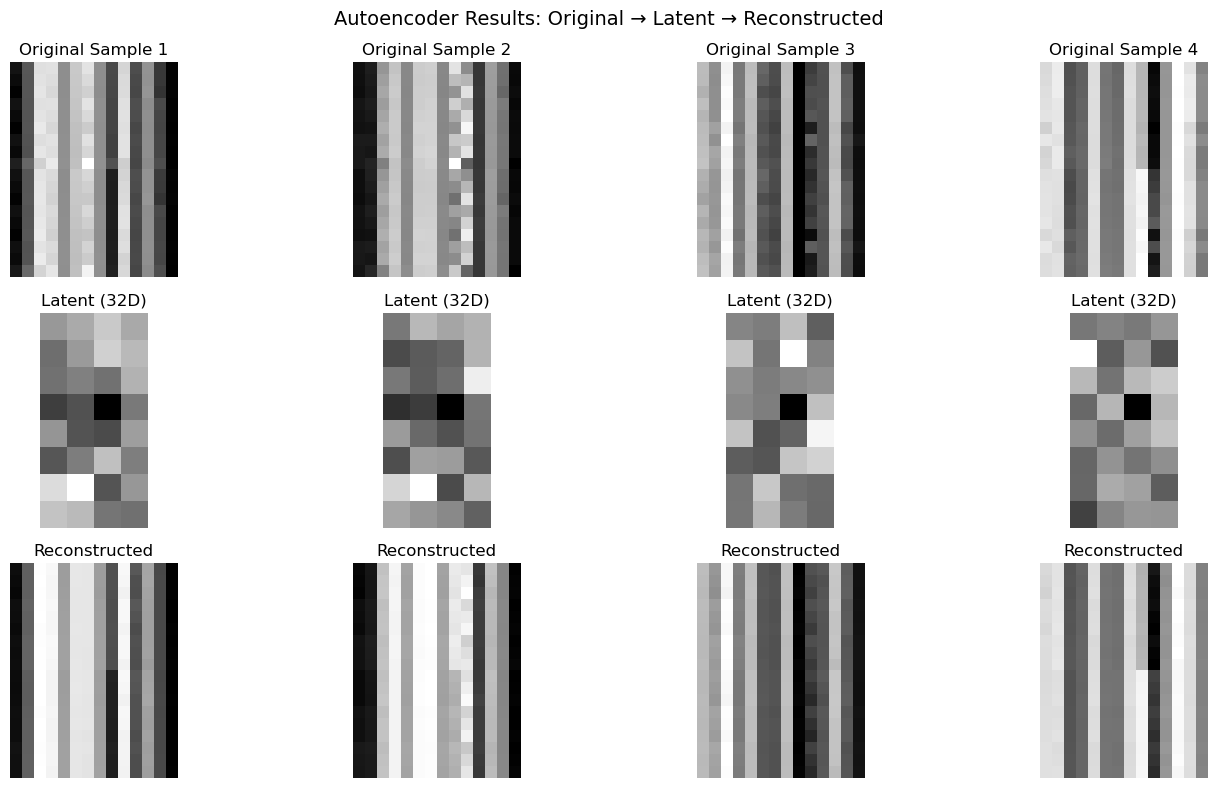

In [6]:
# Generate reconstructions and latent representations
model.eval()
X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)  # Move X_test_tensor to the same device as the model
    reconstructed = model(X_test_tensor).cpu().numpy()
    latent_representations = model.encode(X_test_tensor).cpu().numpy()

print(f"Original data shape: {X_test_normalized.shape}")
print(f"Latent representations shape: {latent_representations.shape}")
print(f"Reconstructed data shape: {reconstructed.shape}")

# Visualize samples in different representations
n_samples = 4
fig, axes = plt.subplots(3, n_samples, figsize=(15, 8))

for i in range(n_samples):
    # Original (normalized)
    axes[0, i].imshow(X_test_normalized[i].reshape(18, 14), cmap='gray')
    axes[0, i].set_title(f'Original Sample {i+1}')
    axes[0, i].axis('off')
    
    # Latent representation (32D → 8x4 for visualization)
    axes[1, i].imshow(latent_representations[i].reshape(8, 4), cmap='gray')
    axes[1, i].set_title(f'Latent (32D)')
    axes[1, i].axis('off')
    
    # Reconstructed
    axes[2, i].imshow(reconstructed[i].reshape(18, 14), cmap='gray')
    axes[2, i].set_title(f'Reconstructed')
    axes[2, i].axis('off')

plt.suptitle('Autoencoder Results: Original → Latent → Reconstructed', fontsize=14)
plt.tight_layout()
plt.show()

## 4.2 Quantitative Evaluation
Reconstruction Error per Feature: in original scale

In [7]:
# Calculate MSE per feature
reconstructed_inv = scaler.inverse_transform(reconstructed)
X_test_numpy = X_test.cpu().numpy()  # Convert X_test (Tensor) to NumPy array
reconstructed_mse = np.mean((reconstructed_inv - X_test_numpy) ** 2, axis=0)
reconstructed_nrmse = np.sqrt(reconstructed_mse) / np.std(X_test_numpy, axis=0)
print(reconstructed_inv.shape)
print(f"\nReconstruction Error per Feature: in original scale")
print(f"{'Feature':>10} {'MSE':>20} {'NRMSE':>20}")
for i in range(0, len(reconstructed_mse), 1):  # Sample every 20th feature
    print(f"{i+1:>10} {reconstructed_mse[i]:>20.4f} {reconstructed_nrmse[i]:>20.4f}")

print("Mean NRMSE: ", np.mean(reconstructed_nrmse), "Max NRMSE: ", np.max(reconstructed_nrmse))

(2000, 252)

Reconstruction Error per Feature: in original scale
   Feature                  MSE                NRMSE
         1               0.2175               0.0895
         2               0.3738               0.1217
         3               0.1856               0.1223
         4               0.0381               0.0692
         5            1620.6250               0.0639
         6               0.0251               0.0634
         7               0.0246               0.0626
         8            1630.6396               0.0641
         9      8527065600.0000               0.0900
        10       500907392.0000               0.2411
        11               0.0000               0.3163
        12             549.3501               0.1824
        13               0.0235               0.1016
        14               0.0102               0.0871
        15               0.1445               0.0731
        16               0.3303               0.1145
        17               0.1859   

In [8]:
# Calculate MSE per feature
reconstructed_mse = np.mean((reconstructed - X_test_normalized) ** 2, axis=0)
reconstructed_nrmse = np.sqrt(reconstructed_mse) / np.std(X_test_normalized, axis=0)

print(f"\nReconstruction Error per Feature: in normalized scale")
print(f"{'Feature':>10} {'MSE':>20} {'NRMSE':>20}")
for i in range(0, len(reconstructed_mse), 1):  # Sample every 20th feature
    print(f"{i+1:>10} {reconstructed_mse[i]:>20.4f} {reconstructed_nrmse[i]:>20.4f}")


Reconstruction Error per Feature: in normalized scale
   Feature                  MSE                NRMSE
         1               0.0086               0.0895
         2               0.0112               0.1217
         3               0.0118               0.1223
         4               0.0038               0.0692
         5               0.0027               0.0639
         6               0.0030               0.0634
         7               0.0029               0.0626
         8               0.0028               0.0641
         9               0.0088               0.0900
        10               0.0503               0.2411
        11               0.0362               0.3163
        12               0.0469               0.1824
        13               0.0097               0.1016
        14               0.0057               0.0871
        15               0.0057               0.0731
        16               0.0099               0.1145
        17               0.0119             

# 5. Model Saving

## 5.1 Save Trained Model and Scaler
Save the trained autoencoder and data scaler for future use.

In [ ]:
# Save model and preprocessing components
SAVE_MODEL = False

if SAVE_MODEL:
    import joblib
    import os
    
    # Create model directory if it doesn't exist
    os.makedirs('model', exist_ok=True)
    
    # Save the scaler
    joblib.dump(scaler, 'model/scaler.save')
    print("Scaler saved to 'model/scaler.save'")
    
    # Save the model state dictionary
    torch.save(model.state_dict(), 'model/autoencoder_model.pth')
    print("Model saved to 'model/autoencoder_model.pth'")

Scaler saved to 'model/scaler.save'
Model saved to 'model/autoencoder_model.pth'
